# Telling a Story with Data
Businesses need to make decisions now about spending money for the future, yet the uncertainty 
of the future makes this difficult. In this coding exercise, we'll use linear and logistic 
regression to make predictions and tell two stories with data. 

This exercise has two parts.

1. Use linear regression to determine whether a food truck owner should expand to a new city.
2. Use logistic regression to determine whether students are likely to pass a course based on their past test score and predicted score for an upcoming test.

## Preliminary Step: Create Infrastructure
Run the following cell to load all the libraries and custom built functions that 
we'll need for this exercise. After running the cell, you will see text below indicating that needed libraries are installed.

In [4]:
import sys
!{sys.executable} -m pip install scikit-plot
import scikitplot as skp

from scikitplot.metrics import plot_roc
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

def plot_regr(X, y, regr):
    regr.fit(X, y)
    plt.plot(X, y, 'o', label = 'Data')
    y_pred = regr.predict(X)
    label = 'y = %.2f + %.2f*x' % (regr.intercept_, regr.coef_)
    plt.plot(X, y_pred, '-b', label = label)
    title = "Truck Profit (y) vs. City Population (x)"
    plt.xlabel("City Population (10,000s)")
    plt.ylabel("Truck Profit ($10,000s)")
    y_pred = regr.predict(X)
    text = "$R^2$ = %.2f" % r2_score(y_pred, y)
    plt.text(13.75, 21, text)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_log(X, y, clf):
    clf.fit(X, y)

    plt.figure(figsize = (8,8))
    passed = np.where(y == 1)[0]
    failed = np.where(y == 0)[0]
    plt.plot(X[passed,0], X[passed,1], '+', label = 'Passed')
    plt.plot(X[failed,0], X[failed,1], 'o', label = 'Failed')
    plt.xlabel("Exam 1 Score")
    plt.ylabel("Exam 2 Score")
    plt.title("Predicting Pass Rates with Logistic Regression")
    coeff = np.insert(clf.coef_, 0, clf.intercept_)
    coeff = coeff / coeff[2]
    coeff[:2] = -1 * coeff[:2]
    pred = lambda x: coeff[0] + coeff[1]*x
    x_min, x_max = X[:,0].min(), X[:,0].max() 
    t = np.arange(x_min, x_max)
    plt.plot(t, pred(t), '-b', label = 'Decision Boundary')
    text = 'y = %.2f + %.2f*x' % (coeff[0], coeff[1])
    plt.text(60, 30, text)
    y_pred = clf.predict(X)
    text2 = "$R^2$ = %.2f" % r2_score(y_pred, y)
    plt.text(60, 25, text2)
    plt.legend()
    plt.show()

def plot_sigmoid():
    s = lambda x: 1 / (1 + np.exp(-x))
    t = np.arange(-10, 10, .5)
    plt.plot(t, s(t), '-b')
    a = np.arange(-10, 0, .5)
    plt.plot(a, [0.5]*len(a), '--r')
    b = np.arange(0, 0.5, .01)
    plt.plot([0]*len(b), b, '--r')
    plt.annotate('A common threshold: 50%', xy=(0, 0.5), xytext=(1, .65),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    plt.title("The Sigmoid Function")
    plt.xlabel("$X$")
    plt.ylabel("$P(X)$")
    plt.show()
    
    
def plot_gd(X, y, theta, Js):
    fig, (ax0, ax1) = plt.subplots(1,2, figsize = (10, 10))
    ax0.plot(X, y, 'o', label = 'Data')
    label = 'y = %.2f + %.2f*x' % (theta[0], theta[1])
    # mod X to make math work
    X_mod = np.insert(X, 0, 1, axis = 1)
    y_pred = X_mod.dot(theta)
    ax0.plot(X, y_pred, '-b', label = label)
    ax0.set_xlabel("City Population (10,000s)")

    text = "$R^2$ = %.2f" % r2_score(y_pred, y)
    ax0.text(6, 22, text)
    ax0.set_ylabel("Truck Profit ($10,000s)")
    ax0.set_title("Truck Profit (y) vs. City Population (x)")
    ax0.legend()

    t = np.arange(1, len(Js)+1)
    ax1.plot(t, Js, '.') 
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Cost (MSE)")
    ax1.set_title("Gradient Descent Cost Minimization")
    plt.show()

def gradient_descent(X, y, theta, alpha, iterations):
    # insert columns of ones to make math work
    X = np.insert(X, 0, 1, axis = 1)
    n_rows, n_cols = X.shape
    J_hist = np.zeros(iterations)

    for _ in range(iterations):

        J = 0
        temps = np.zeros(n_cols)
        grads = np.zeros(n_cols)

        # Our prediction.
        h = lambda a: a.dot(theta)

        # Cost function is mean-squared-error.
        for i in range(n_rows):
            J += ( h(X[i, :]) - y[i] )**2 / (2*n_rows)
        J_hist[_] = J

        # Compute gradients and place them in a temporary variable.
        for j in range(n_cols):
            for i in range(n_rows):
                grads[j] += ( h(X[i, :]) - y[i] ) * X[i,j] / n_rows

            temps[j] = theta[j]- alpha*grads[j]

        # Simultaneous update.
        for j in range(n_cols):
            theta[j] = temps[j]

    return theta, J_hist
        

## Part 1: Predict Food Truck Profitability with Linear Regression

In this part, we'll examine the case of a food truck owner who is interested in expanding 
to a new city, but first wants to determine whether this idea is likely to be profitable. To 
increase our confidence in the results, we'll use two different tools, the **sklearn library** and 
the **gradient descent algorithm**, to run two linear regression operations that show the relationship 
between city population and food truck profitability. 

### Step 1: Run a Linear Regression with the sklearn Library 

The first linear regression we'll run uses **sklearn**, a pre-built Python library. Run the following 
cell to load historical food truck data and create a plot.


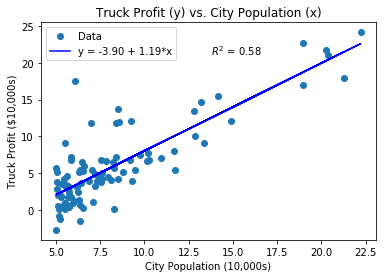

In [5]:
address = 'ex1data1.txt'
data = pd.read_csv(address, header = None).values

X, y = data[:,:-1], data[:,-1]
regr = linear_model.LinearRegression()
plot_regr(X, y, regr)


This plot shows that a relationship does exist between the population of a city and the 
profitability of food trucks in that city.

### Step 2: Run a Linear Regression with the Gradient Descent Algorithm
Next, we'll use an algorithm called **gradient descent** to run a second linear regression. 
We have customized this algorithm for our situation. 

Run the following cell to create a plot of the gradient descent.

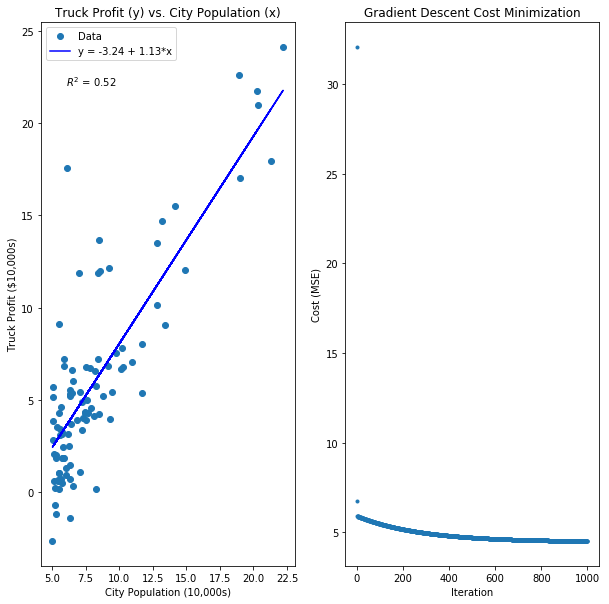

In [3]:
initial_theta = np.zeros(2)
learning_rate = .01
iterations = 1000

theta, J_hist = gradient_descent(X, y, initial_theta, 
                                learning_rate, iterations)

plot_gd(X, y, theta, J_hist)


Like the plot that we created using sklearn, this plot shows that the population of a city relates to the profitability of food trucks in that city. 

#### More Information: Gradient Descent 
Linear regression works by minimizing the residuals between the prediction and true values. The gradient descent algorithm minimizes this cost function. 

To understand how gradient descent works, imagine you're on top of a hill, blindfolded, and want to go down the hill. Which direction should you go? You can feel which way leads down most steeply, so you go that direction, and continue to feel for the direction of steepest descent until you reach the bottom of the hill. Gradient descent works similarly, until it reaches the minimum of the cost function. 

### Step 3: Interpret the Linear Regression Results 
The answers from the sklearn library and the gradient descent algorithm are fairly equal. Both plots show that a relationship exists between the population of a city and the profitability of food trucks in that city. We can be confident that a relationship exists between city population and food truck profitability. This prediction is not completely certain, but does eliminate some risk. 

#### More Information: $R^2$ 
The gradient descent graph includes an equation for a prediction and an $R^2$ value. The
coefficients of the equation describe the sensitivity of profit to changes in
population:

- The intercept indicates that if a food truck owner adds a food truck in a town that has zero residents, the food truck owner will lose $32,400.

- The coefficient of x indicates that for every increase in city population by 10,000, the truck will make an additional $11,300.

The $R^2$ value describes how well our prediction models fit the data used to train it. $R^2$:

- is in [0,1]
- the closer to one, the more the model explains the variance in the data. 


## Part 2: Predict Student Outcomes with Logistic Regression

In this part, we'll determine whether students who earn specific scores on two tests are likely to pass a course. We don't know the minimum passing score for the course, so we'll use logistic regression, which provides "yes/no" or "true/false" answers to questions based on two variables.

This logistic regression uses the sklearn library that we used in part 1.

### Step 1: Load the Data 

Run the following cell to load a dataset of exam scores that are labelled as either passing or failing. 


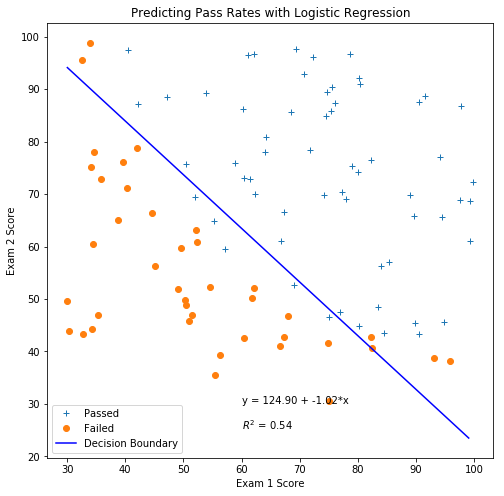

In [6]:
address = 'ex2data1.txt'
data = pd.read_csv(address, header = None).values
X = data[:,:-1]; y = data[:,-1]
clf = linear_model.LogisticRegression(solver='lbfgs')
plot_log(X, y, clf)


### Step 2: Run a Logistic Regression for Student 1
Now that we've loaded the dataset, we can make predictions about student outcomes. 

In this example, a student scored 50 on the first exam because she was sick. She thinks 
she can score 90 on the next exam.

Run the following cell to determine whether this student, based on past data, is likely to pass the course.

In [7]:
data_array = np.array([[50, 90]])
prob_pass = clf.predict(data_array)
print("The probability of passing with %s: %.2f" % (data_array, prob_pass))

The probability of passing with [[50 90]]: 1.00


We can see that with scores of 50 and 90, she is likely to pass the course. You can experiment by changing the `50` and `90` in the first line of code in the cell above and observing how the results change.

### Step 3: Run a Logistic Regression for Student 2

What is the likelihood that a student who makes a 60 on exam 1 and a 64 on exam 2 passes the course?

Enter the values for the `data_array` and `prop_pass` variables below, using the previous cell as an example.

**Note**: To see the code that we used, see **Answer Code** below the code cell.

In [8]:
#-----------Enter Your Code Here------------#
data_array = np.array([[60, 64]])
prob_pass = clf.predict(data_array)
print("The probability of passing with %s: %.2f" % (data_array, prob_pass))
#-------------------------------------------#

The probability of passing with [[60 64]]: 1.00


#### Answer Code
We used the following code in the code cell.

```python
#-----------Enter Your Code Here------------#
data_array = np.array([[60, 64]])
prob_pass = clf.predict(data_array)
print("The probability of passing with %s: %.2f" % (data_array, prob_pass))
#-------------------------------------------#
```

### Step 4: Interpret the Logistic Regression Results

Logistic regression uses the sigmoid function to answer a yes/no question. 
#### The Sigmoid Function
Logistic regression works similarly to linear regression, by finding weights through
gradient descent that minimize its cost function (something different than the
residuals). 

It takes the dot product of exam scores and solved-coefficients to
come up with a real-value. Next, it turns that value into a probability by 
passing it through the sigmoid function. Finally, each training example of exam
scores is classified as passing or not based on a chosen probability threshold,
usually 50%. 

The sigmoid function is very useful because it maps all real-values to (0, 1).

To see this visually, run the following cell.

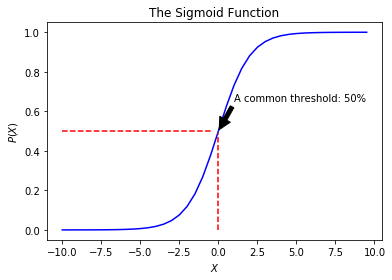

In [9]:
plot_sigmoid()

As you can see, no matter how large X is, P(X) is no higher than 1. Likewise,
no matter how small X, P(x) is no lower than 0. 

#### The Coefficients
The process for interpreting the coefficients in logistic regression is similar 
to the process for linear regression. The difference is we talk in terms of percentages instead of
real-values.

- The intercept can be interpreted as the minimum exam 2 score required
  to pass. If you score 0 on exam 1, our model says you need to score ~125%
  on exam 2.
- The coefficient of x is interpreted as the change in exam 2 score required 
  to pass for a 1% increase in the exam 1 score. If you score 1% higher on exam 1,
  you will need 1.02% less on exam 2 in order to pass.


#### ROC curves
Receiver operating characteristic (ROC) curves give us a way to compare the rate of correctly passing exam scores
(predicted) to the rate of falsely passing exam scores (predicted). If you
change the classification threshold (usually 50%), these values will vary, which is what
produces the curve. Let's take a look at the ROC for the exam scores.

Run the following cell.

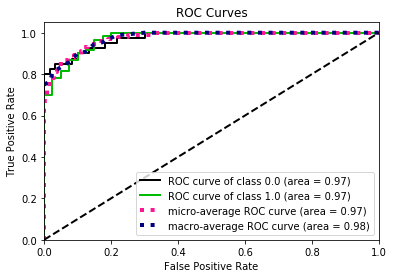

In [10]:
y_pred = clf.fit(X, y).predict_proba(X)
        
# FPR(T) and TPR(T) are functions of the acceptance threshold T
# The ROC plots the (fpr, tpr) pairs that result from varying T
plot_roc(y, y_pred)
plt.show()


Look at the point (0,0.6) for class 1; it is telling you that for the
chosen pass threshold, you can expect a false-positive (FPR) rate of 0% and a
true-positive rate (TPR) of 60%. A perfect score would be 100%, which would happen
if the curve was in the far left corner of the graph. This also corresponds to 
an area under the curve of 1.

Google is famous for not wanting any false positives in its hiring decisions, 
so the company might choose a threshold with a 0% FPR.

## Conclusion: The Story the Data Tells
In this exercise, we saw how a food truck owner can use linear regression to predict 
how profitable a new truck in a new city will be. 

We then saw how a student could use logistic regression to predict
what score she would need on an exam to be fairly confident that she would pass the course.

These tools are effective for simple problems, but business data is often more complicated 
and has more variables. We'll learn about multivariable regression in the next coding exercise. 
